# **PHẦN 1: BÁO CÁO VÀ NGƯỜI DÙNG DỰ ĐOÁN**

**1. BÀI TOÁN:**
- Dự đoán giá cổ phiếu sau N (thời gian) kể từ current time.
- Bộ dữ liệu: Chọn bộ dữ liệu đại diện là FPT.csv.

**2. XÁC ĐỊNH BÀI TOÁN:**
- Ouput: Giá cổ phiếu ('Close').
- Input: Các features còn lại trong dataset.
- Note: Trong bài toán này, em đặt ra 2 output. Close và Volumn nhằm đưa ra thêm dự đoán về số lượng cố phiếu bán ra.

**3. QUY TRÌNH:**
- Bước 1: Xem xét data.
- Bước 2: Phân tích các thuộc tính (feature) trong data bằng các phương pháp thống kê.
- Bước 3: Loại bỏ, xử lý các features. Đưa ra input, output cho mô hình.
- Bước 4: Định nghĩa mô hình - Huấn luyện - Đánh giá.
- Bước 5: Hoàn thiện demo bằng code cơ bản cho người dùng. (Trình bày ngay bên dưới đây)


%%%Thông tin: Đinh Văn Nguyên - nguyendv02@gmail.com

# **Chạy hàm phục vụ dự đoán**

In [1]:
import os
import zipfile
from datetime import datetime, timedelta
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tqdm import tqdm
import joblib
from joblib import dump, load

In [2]:
def load_Data(extracted_folder_path = './content', data_input_path = 'last_input.npy', model_path = 'model.h5', scaler_path = 'scaler_model.joblib'):

    X_input = np.load(os.path.join(extracted_folder_path, data_input_path))
    model_predict = load_model(os.path.join(extracted_folder_path, model_path), compile=False)
    scaler = joblib.load(os.path.join(extracted_folder_path, scaler_path))

    return X_input, model_predict, scaler

In [3]:
def UserInput():
    print()
    print('         ---------- LƯU Ý ----------')
    print('Current time được định nghĩa là dòng cuối cùng trong dữ liệu train.')

    t1 = datetime(2020, 10, 21)

    # Nhập số ngày, giờ, phút muốn thêm vào t1
    day = int(input("Days: "))
    hour = int(input("Hours: "))
    minute = int(input("Minutes: "))

    # Tính thời gian t2
    t2 = t1 + timedelta(days=day, hours=hour, minutes=minute)

    # In thời gian t1
    print(f'Current time: {t1.strftime("%I:%M %p %m/%d/%Y")} (hh:mm AM/PM mm/dd/yyyy).')

    # In thời gian t2
    print(f'User input: {t2.strftime("%I:%M %p %m/%d/%Y")} (hh:mm AM/PM mm/dd/yyyy).')
    print()

    return day, hour, minute, t1, t2

In [4]:
def ProcessTimeInput(day, hour, minute, X_input):
    # Lấy giá trị thời gian cuối cùng của X_train tương ứng với thời gian hiện tại
    last_time = X_input[0][X_input.shape[1]-1][2]

    # Scale time như lúc train
    # Scale MinMax. Các con số dưới đây là min max ở tập dữ liệu
    time_scaled = day + ((hour*60 + minute)-555)/(886-555+1)

    flag = True
    if day + ((hour*60 + minute)-555)/(886-555+1) < 0:
        flag = False

    if time_scaled > day+1:
        time_scaled = day + (886-555)/(886-555+1)

    time_scaled = int(last_time)+1 + time_scaled

    list_time = np.arange(int(last_time)+1+0.01, time_scaled+0.001, 0.01)

    return list_time, flag

In [5]:
def Predict(list_time, X_input, model_predict):
    list_close_volumn = []
    sequence_len = X_input.shape[1]

    for pred_time in list_time:

        # Gán time point tiếp theo và predict
        X_input[0][sequence_len-1][2] = pred_time
        y_pred = model_predict.predict(X_input, verbose = 0)

        # Lưu close và volumn
        temp = []
        temp.append(y_pred[0][0])
        temp.append(y_pred[0][1])
        list_close_volumn.append(temp)

        # Thêm data mới và remove data cũ
        X_input = X_input[:, 1:, :]
        X_input[:,-1,:] = [temp[0], temp[1], pred_time]
        new_rows = np.array([0,0,0])
        X_input = np.concatenate((X_input, new_rows.reshape(1, 1, 3)), axis=1)

    return list_close_volumn

In [6]:
def Inverse_Close_Volumn(data, scaler):
    data = np.array(data)
    data = data.reshape(1, -1)
    list_inverse = scaler.inverse_transform(data)
    return list_inverse

In [7]:
def PrintOutput(list_close_volumn, t2, scaler):
    list_result = Inverse_Close_Volumn(list_close_volumn[len(list_close_volumn)-1], scaler)
    print('         ---------- DONE ----------')

    # Format lại kết quả
    close = '{:.2f}'.format(list_result[0][0], 2)
    volumn = math.ceil(list_result[0][1]) if list_result[0][1] >= 0.5 else math.floor(list_result[0][1])

    print(f'At {t2}. Close = {close}, Volumn = {volumn}.')

In [8]:
def Download_Extract(zip_file_path = './FPTStock.zip', extracted_folder_path = './content'):
    if not os.path.exists(zip_file_path):
        !gdown 1lcKjyIi1DW3i9pyvYLvb7_9rEczbajxj

        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extracted_folder_path)
    else:
        print("FPT.zip already exists. Skipping download.")

        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extracted_folder_path)

In [9]:
def Main():

    zip_file_path = './FPTStock.zip'
    extracted_folder_path = './content'

    # Download và extract một số dữ liệu để predict
    Download_Extract()

    # Load dữ liệu vừa extract
    X_input, model_predict, scaler = load_Data()

    # Người dùng nhập vào
    day, hour, minute, t1, t2 = UserInput()

    list_time, flag = ProcessTimeInput(day, hour, minute, X_input)

    if flag:
        list_close_volumn = Predict(list_time, X_input, model_predict)

        PrintOutput(list_close_volumn, t2, scaler)
    else:
          print('The trading session has not opened.')

# **Demo**

In [11]:
Main()

FPT.zip already exists. Skipping download.

         ---------- LƯU Ý ----------
Current time được định nghĩa là dòng cuối cùng trong dữ liệu train.
Current time: 12:00 AM 10/21/2020 (hh:mm AM/PM mm/dd/yyyy).
User input: 04:02 AM 10/22/2020 (hh:mm AM/PM mm/dd/yyyy).

         ---------- DONE ----------
At 2020-10-22 04:02:00. Close = 51.67, Volumn = 5461.


# **PHẦN 2: CODE VÀ PHÂN TÍCH**

## **EDA Data**

### **Xem qua về dữ liệu**

In [4]:
df = pd.read_csv('/content/FPT.csv')
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


**----- XỬ LÝ NGÀY THÁNG -----**

Do định dạng ngày tháng như vậy không phù hợp với việc đưa vào model nên chúng tôi xử lý ngày tháng như sau:
- Lấy ngày đầu tiên làm mốc (date = 1).
- Mỗi ngày sẽ lấy số phút = hour*60 + minute.
- Ở đây chúng tôi sử dụng model time series, do đó cần format lại dữ liệu về thời gian:
  + Mỗi ngày sẽ được đánh số nguyên, bắt đầu từ 1.
  + Dữ liệu phút trong 1 ngày sẽ được MinMaxScaler, với min là 9:15 AM và max là 2:46PM (min và max được trích xuất từ data).
  + Sau đó, cộng data và time (đã được scale). Vì vậy, dữ liệu thời gian sẽ đảm bảo rằng: Mỗi ngày là khoảng từ [x, x+1)

In [ ]:
df['date'] = ""
df['time_in_date'] = ""

count = 1
for index, item in tqdm(enumerate(df['Date/Time'])):
    if index == 0:
        # Minute present row
        h, m = item.split(' ')[1].split(':')
        minute = int(h)*60 + int(m)
        df['time_in_date'][index] = minute
        df['date'][index] = count
        continue

    # Minute above row
    minute_b4 = df['time_in_date'][index-1]

    # Minute present row
    h, m = item.split(' ')[1].split(':')
    minute = int(h)*60 + int(m)

    # Set value for 2 column have been created
    df['time_in_date'][index] = minute
    if minute < minute_b4:
        count = count + 1
    df['date'][index] = count

In [6]:
print(max(df['time_in_date']))
print(min(df['time_in_date']))

886
555


In [ ]:
df['time_scaled'] = ""
max_time = max(df['time_in_date'])
min_time = min(df['time_in_date'])
for index, item in tqdm(enumerate(df['time_in_date'])):
    scaled_timeinday = (item - min_time)/(max_time - min_time + 1)
    df['time_scaled'][index] = df['date'][index] + scaled_timeinday

In [8]:
df = df.drop(['Date/Time', 'date', 'time_in_date'], axis = 1)

In [9]:
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest,time_scaled
0,FPT,30.89,30.89,30.89,30.89,35410,0,1.0
1,FPT,30.81,30.81,30.81,30.81,190,0,1.003012
2,FPT,30.74,30.81,30.74,30.74,1120,0,1.006024
3,FPT,30.74,30.74,30.74,30.74,2120,0,1.009036
4,FPT,30.74,30.74,30.74,30.74,22500,0,1.012048


### **Trực quan bằng mathplotlib và seaborn**

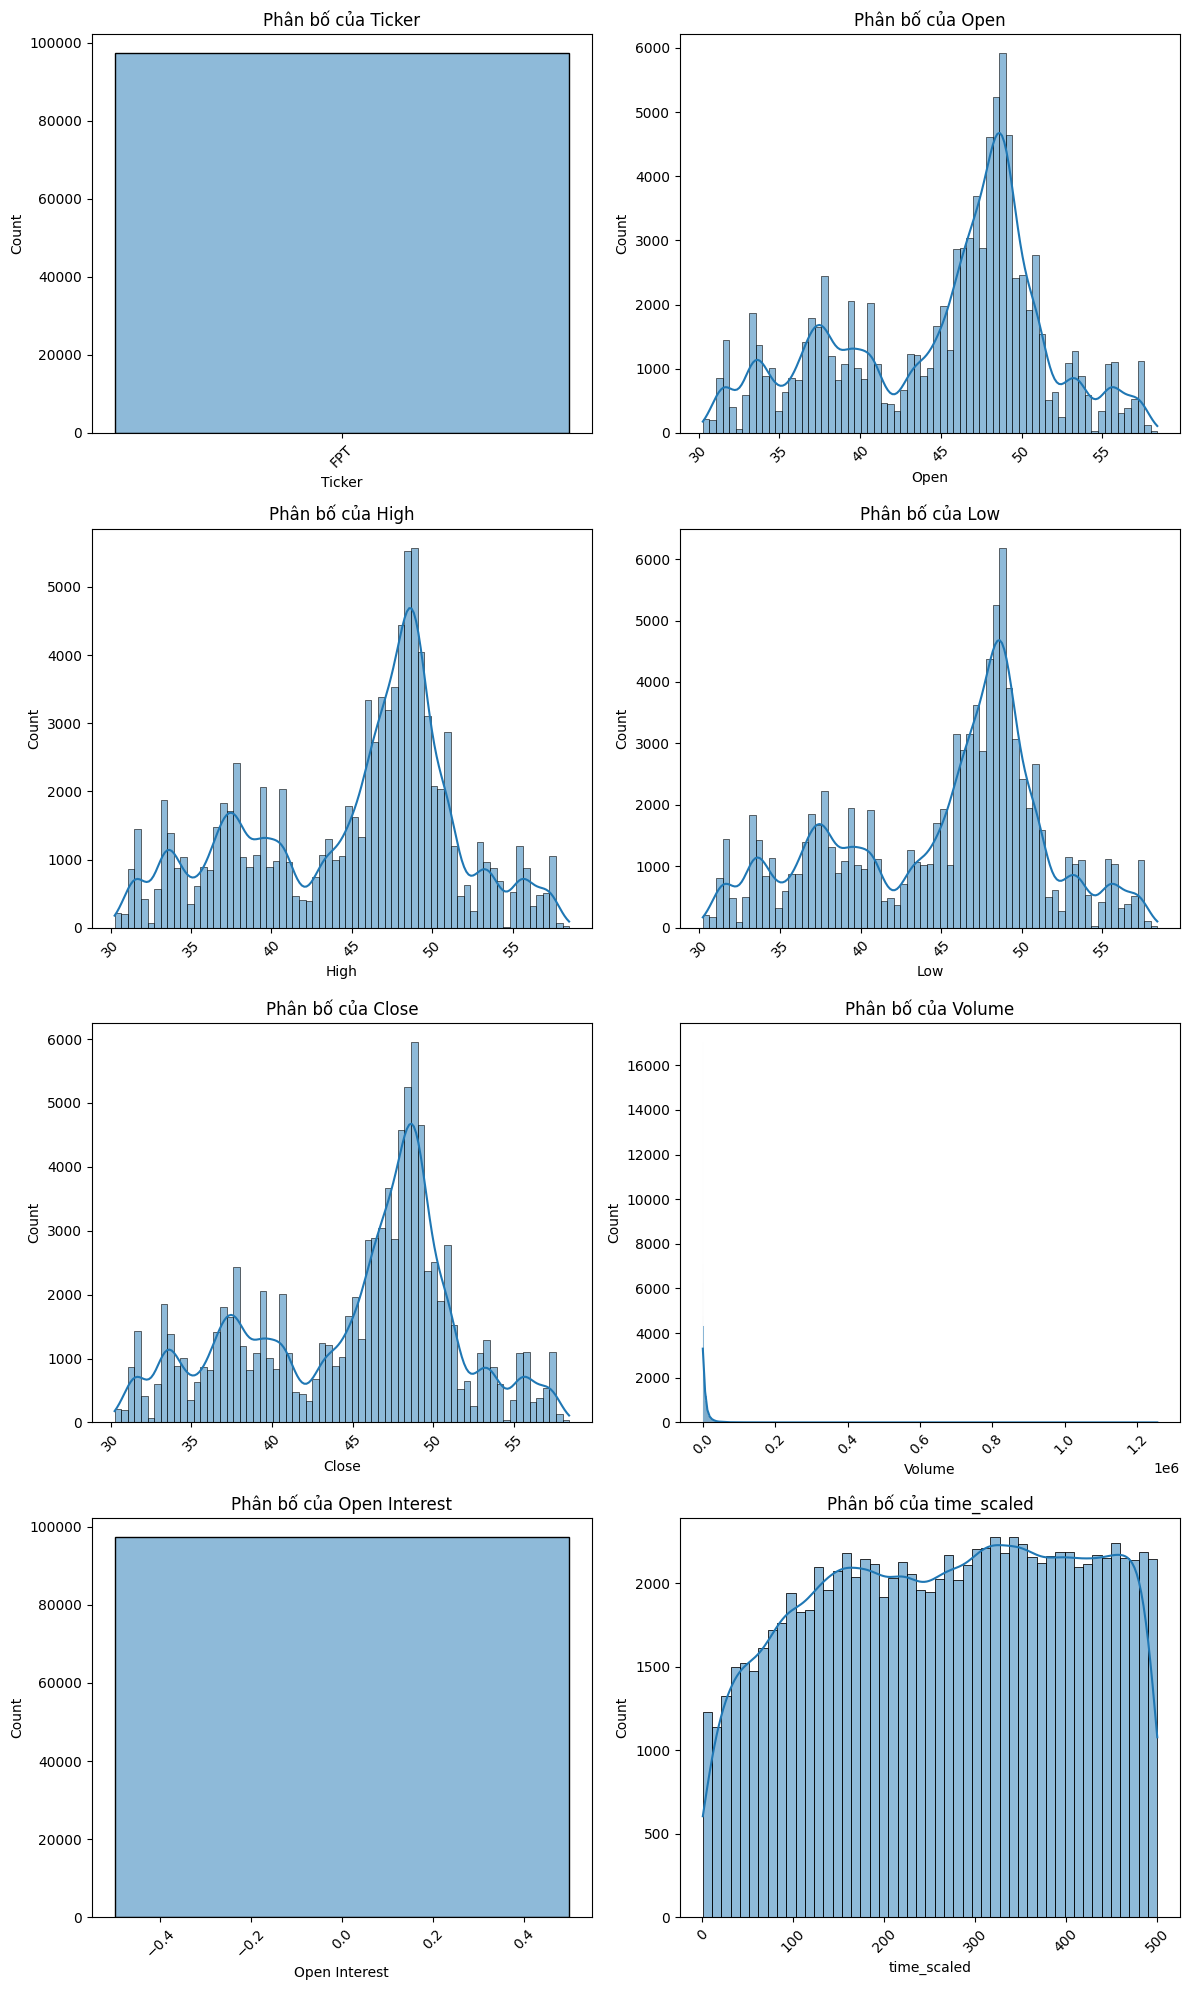

In [ ]:
# Số lượng cột trong DataFrame
num_columns = len(df.columns)

# Số lượng hình trong mỗi hàng
plots_per_row = 2

# Số lượng hàng
num_rows = (num_columns + plots_per_row - 1) // plots_per_row

# Kích thước biểu đồ
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(12, 5 * num_rows))

# Vòng lặp for để vẽ biểu đồ phân bố cho từng cột
for i, column in enumerate(df.columns):
    row, col = divmod(i, plots_per_row)
    sns.histplot(df[column], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Phân bố của {column}')

# Xoay trục x để tránh chồng lên nhau
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<ipython-input-12-db0ce8e21d00>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


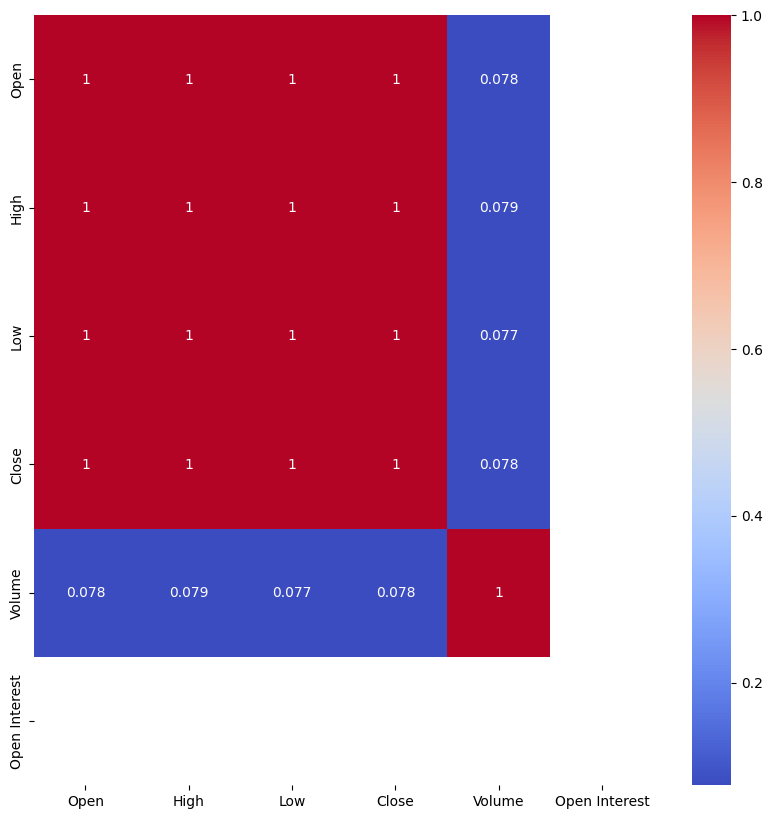

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

## **Feature Selection**

**Sau khi vẽ phân phối giá trị và Pearson Correlation. Ta nhận thấy 3 điều sau:**
1.   Feature 'Low', 'High', 'Open', 'Close'có tương quan tiệm 1.
2.   Feature 'Open Interest' có tất cả giá trị bằng 0.
3.   Ticker đều là FPT.

**=> Nên ta loại bỏ các feature: 'Ticker', 'Low', 'High', 'Open' và 'Open Interest' do không có nhiều giá trị đối với biến mục tiêu.**

In [10]:
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest,time_scaled
0,FPT,30.89,30.89,30.89,30.89,35410,0,1.0
1,FPT,30.81,30.81,30.81,30.81,190,0,1.003012
2,FPT,30.74,30.81,30.74,30.74,1120,0,1.006024
3,FPT,30.74,30.74,30.74,30.74,2120,0,1.009036
4,FPT,30.74,30.74,30.74,30.74,22500,0,1.012048


In [11]:
data = df.drop(['Ticker', 'Open', 'High', 'Low', 'Open Interest'], axis = 1)

In [12]:
data.head(10)

,Close,Volume,time_scaled
0,30.89,35410,1.0
1,30.81,190,1.003012
2,30.74,1120,1.006024
3,30.74,2120,1.009036
4,30.74,22500,1.012048
5,30.74,7140,1.01506
6,30.66,16480,1.018072
7,31.11,2650,2.0
8,31.19,500,2.003012
9,31.19,510,2.006024


## **Prepare data for model**

In [13]:
data = df[['Close', 'Volume', 'time_scaled']]

In [ ]:
scaler = StandardScaler()

# Scale các cột đã chọn
data[['Close', 'Volume']] = scaler.fit_transform(data[['Close', 'Volume']])

# Nối lại với cột 'time_scaled'
scaled_df = pd.concat([data[['Close', 'Volume']], data['time_scaled']], axis=1)

# Chuyển DataFrame thành mảng NumPy
data = scaled_df.values

In [15]:
# Save the scaler to a file
scaler_filename = '/content/scaler_model.joblib'
joblib.dump(scaler, scaler_filename)

['/content/scaler_model.joblib']

In [16]:
def RawData_To_Sequences(data_, time_steps, overlap):
    # Tạo các index point cho sequence, nếu không có overlap thì không tối ưu được kích thước data.
    data = data_[:-overlap]
    overlap_ = time_steps - overlap #int(overlap * time_steps)
    y_index = np.arange(time_steps, len(data), time_steps - overlap_)

    # Lấy giá trị mục tiêu từ index point
    y = data[y_index, :2]

    # Lấy tập train từ index point
    rows_X = len(y)

    temp_list = []
    for i in range(rows_X):
        # temp = data[y_index[i]-time_steps: y_index[i],:]
        # temp_list.append(temp)

        temp = data[y_index[i] - time_steps: y_index[i], :]

        # Thêm dòng với tất cả giá trị 0 và giá trị cuối cùng là 1
        zero_row_with_nexttime = np.zeros(temp[0].shape)
        zero_row_with_nexttime[-1] = data_[y_index[i]][2]
        temp_with_zero_row = np.vstack([temp, zero_row_with_nexttime])

        temp_list.append(temp_with_zero_row)


    X = np.vstack(temp_list)
    X = X.reshape((rows_X, time_steps+1, data.shape[1]))

    return X, y

In [28]:
n_timesteps = 400
X, y = RawData_To_Sequences(data, n_timesteps, 1)

In [29]:
def train_test_split_DIY(X, y, test_size = 0.1):
    train_samples = int((1-test_size)*X.shape[0])
    X_train = X[:train_samples]
    X_test = X[train_samples:]
    y_train = y[:train_samples]
    y_test = y[train_samples:]

    return X_train, X_test, y_train, y_test

In [30]:
X_train, X_test, y_train, y_test = train_test_split_DIY(X, y, test_size = 0.1)

In [31]:
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

In [32]:
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [33]:
X_train.shape

(87304, 401, 3)

## **Model**

### **Define Model**

In [34]:
model = Sequential()

# LSTM layer 1
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.25))

# LSTM layer 2
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.25))

# LSTM layer 3
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.25))

# LSTM layer 4
model.add(LSTM(100))
model.add(Dropout(0.25))

model.add(Dense(y_test.shape[1]))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 401, 100)          41600     
                                                                 
 dropout (Dropout)           (None, 401, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 401, 100)          80400     
                                                                 
 dropout_1 (Dropout)         (None, 401, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 401, 100)          80400     
                                                                 
 dropout_2 (Dropout)         (None, 401, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

### **Train  with lr_schedule**

In [ ]:
# Hàm để biến đổi learning rate
def lr_schedule(epoch, learning_rate):
    if epoch < 10:
        return learning_rate
    else:
        return learning_rate * 0.9

# Tạo learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.9,
    staircase=True)

# Định nghĩa các callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=30)
checkpoint_best = ModelCheckpoint('/content/drive/MyDrive/Stock/best_model.h5',
                                  save_best_only=True,
                                  monitor='val_loss',
                                  mode='min',
                                  verbose=1)
checkpoint_last = ModelCheckpoint('/content/drive/MyDrive/Stock/last_model.h5',
                                  save_best_only=False,
                                  monitor='val_loss',
                                  mode='min',
                                  verbose=1)
learning_rate_schedule = LearningRateScheduler(lr_schedule, verbose=1)

# Compile mô hình với Adam optimizer và learning rate schedule
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mean_squared_error', metrics=['mse'])

In [ ]:
# Train the model
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split = 0.1,
                    callbacks=[early_stopping, checkpoint_best, checkpoint_last, learning_rate_schedule])

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### **Train with Fixed lr**

In [35]:
# Định nghĩa các callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=30)
checkpoint_best = ModelCheckpoint('/content/drive/MyDrive/Stock/best_model_sec.h5',
                                  save_best_only=True,
                                  monitor='val_loss',
                                  mode='min',
                                  verbose=1)
checkpoint_last = ModelCheckpoint('/content/drive/MyDrive/Stock/last_model_sec.h5',
                                  save_best_only=False,
                                  monitor='val_loss',
                                  mode='min',
                                  verbose=1)

# Compile mô hình với Adam optimizer và learning rate schedule
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mse'])

In [ ]:
# Train the model
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split = 0.1,
                    callbacks=[early_stopping, checkpoint_best, checkpoint_last])

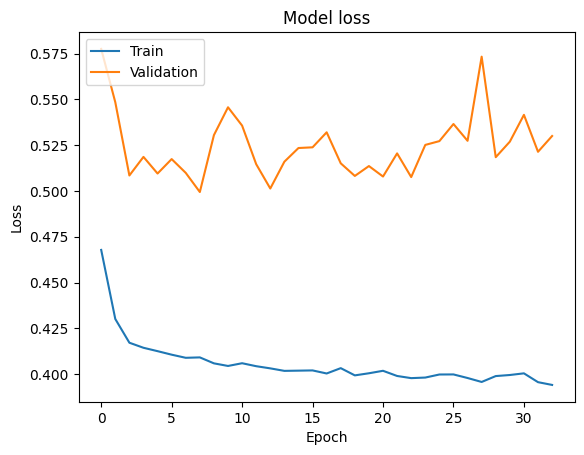

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **Inference Test**

In [38]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")

304/304 [==============================] - 15s 41ms/step
Mean Squared Error (MSE): 0.7770626544952393


In [39]:
y_pred.shape

(9701, 2)

In [40]:
reverse_pred = scaler.inverse_transform(y_pred)
reverse_test = scaler.inverse_transform(y_test)

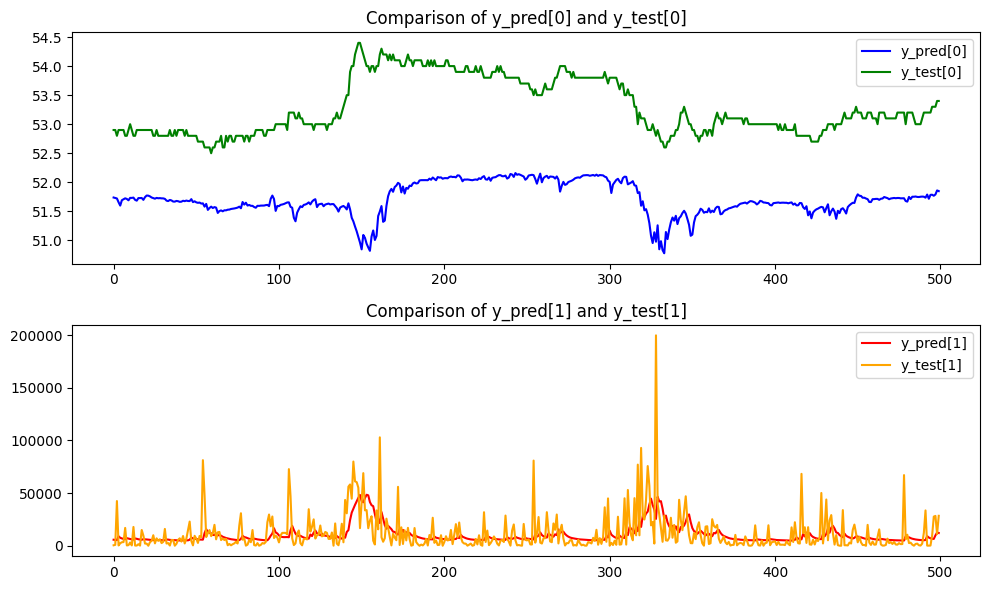

In [43]:
# Lấy giá trị từ cột [0] và [1] của y_pred và y_test
reverse_pred_0 = reverse_pred[:, 0]
reverse_pred_1 = reverse_pred[:, 1]

# Vẽ đồ thị cho y_pred và y_test
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(reverse_pred_0[:500], label='y_pred[0]', color='blue')
plt.plot(reverse_test[:, 0][:500], label='y_test[0]', color='green')
plt.title('Comparison of y_pred[0] and y_test[0]')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(reverse_pred_1[:500], label='y_pred[1]', color='red')
plt.plot(reverse_test[:, 1][:500], label='y_test[1]', color='orange')
plt.title('Comparison of y_pred[1] and y_test[1]')
plt.legend()

plt.tight_layout()
plt.show()